In [143]:
import numpy as np
data2d = '/home/daizj/Homeworks/gv/HW4/data2D/'
R_gt = np.array([[9.811215444923645501e-01, -1.933921273809177666e-01],
                 [1.933921273809177666e-01, 9.811215444923645501e-01]])
t_gt = np.array([[1.629147451076420561e+00],
                [5.212383419509611926e-01]])
p = np.loadtxt(data2d + 'p.txt')
q = np.loadtxt(data2d + 'q.txt')

print("p shape:",p.shape)
print("q shape:",q.shape)

p shape: (20, 2)
q shape: (30, 2)


In [144]:
def compute_lb(p, q, cube, threshold=1e-3):
    t = np.array([np.mean(cube[0:2]), np.mean(cube[2:])])
    p_t = p + t
    dist = []
    for p1 in p_t:
        point_distances = np.linalg.norm(p1) - np.linalg.norm(q, axis=1)
        dist.append(point_distances)
    dist = np.array(dist)
    lower_bound = np.sum(np.abs(dist) <= threshold)
    return lower_bound

def compute_ub(p, q, cube, threshold=1e-3):
    region_p = []
    region_q = []
    interval = 10
    step = (cube[1] - cube[0]) / interval
    t = []
    for i in range(interval):
        for j in range(interval):
            t.append(np.array([cube[0]+i*step, cube[2]+j*step]))

    for point in p:
        min_t = 10000
        max_t = 0
        for i in range(len(t)):
            dist_origin = np.linalg.norm(point + t[i], ord=2)
            if dist_origin > max_t:
                max_t = dist_origin
            if dist_origin < min_t:
                min_t = dist_origin
        region_p.append(np.array([min_t, max_t]))

    dist_q = np.linalg.norm(q, axis=1)
    region_q = [np.array([dist_q[i] - threshold, dist_q[i] + threshold]) for i in range(q.shape[0])]

    upper_bound = 0
    for i in region_q:
        for j in region_p:
            no_intersection = np.logical_or(i[0] >= j[1], i[1] <= j[0])
            if no_intersection == False:
                upper_bound = upper_bound + 1
    return upper_bound

def compute_ub_another(p, q, cube, threshold=1e-3):
    region_p = []
    region_q = []
    t_c = np.array([np.mean(cube[0:2]), np.mean(cube[2:])])
    r = (cube[1]-cube[0])/2
    dist_p_t = np.linalg.norm(p+t_c, axis=1)
    region_p = [np.array([dist_p_t[i] - r, dist_p_t[i] + r]) for i in range(p.shape[0])]
    dist_q = np.linalg.norm(q, axis=1)
    region_q = [np.array([dist_q[i] - threshold, dist_q[i] + threshold]) for i in range(q.shape[0])]

    upper_bound = 0
    for i in region_q:
        for j in region_p:
            no_intersection = np.logical_or(i[0] >= j[1], i[1] <= j[0])
            if no_intersection == False:
                upper_bound = upper_bound + 1
    return upper_bound

def init_cubes(p,q,power = 4): 
    cubes = []
    radius = 0.5
    p_mean = np.median(p, axis=0)
    q_mean = np.median(q, axis=0)
    x_min = -radius + (q_mean[0] - p_mean[0])
    x_max = radius + (q_mean[0] - p_mean[0])
    y_min = -radius + (q_mean[1] - p_mean[1])
    y_max = radius + (q_mean[1] - p_mean[1])
    for i in range(power):
        for j in range(power):
            step_x = (x_max-x_min)/power
            step_y = (y_max-y_min)/power
            cube = np.array([x_min + i * step_x, x_min + (i+1) * step_x, y_min + j * step_y, y_min + (j+1) * step_y]) # [x_min,x_max,y_min,y_max]
            cubes.append(cube)
    return cubes

def split_cubes(cube, power = 2):
    cubes_sp = []
    for i in range(power):
        for j in range(power):
            step = (cube[1] - cube[0]) / power
            cube_sp = np.array([cube[0]+i*step, cube[0]+(i+1)*step, cube[2]+j*step, cube[2]+(j+1)*step]) # [x_min,x_max,y_min,y_max]
            cubes_sp.append(cube_sp)
    return cubes_sp

########## test ##########
cubes = init_cubes(p,q)
print("init cubes",len(cubes))
new_cube = []
lower_bounds = []
upper_bounds = []
for i in cubes:
    lb = compute_lb(p, q, i, threshold=1e-3)
    ub = compute_ub(p, q, i, threshold=1e-3)
    lower_bounds.append(lb)
    upper_bounds.append(ub)
    sp_cube = split_cubes(i)
    new_cube = new_cube + sp_cube
print("new split cubes",len(new_cube))
print("lower bounds:",lower_bounds)
print("upper bounds:",upper_bounds)
# print("new split cubes",new_cube)

init cubes 16
new split cubes 64
lower bounds: [0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1]
upper bounds: [47, 56, 51, 57, 46, 54, 55, 60, 50, 58, 51, 58, 56, 62, 57, 55]


In [145]:
import heapq
def bnb_search(p, q, Q_c, type = 'raw',tolerance=1, threshold=1e-3,best_bound = 0, depth = 0):
    lower_bounds = []
    upper_bounds = []
    for c in Q_c:
        lb = compute_lb(p, q, c, threshold)
        if type == 'raw':
            ub = compute_ub(p, q, c, threshold)
        else:
            ub = compute_ub_another(p, q, c, threshold)
        lower_bounds.append(lb)
        upper_bounds.append(ub)
    if len(Q_c)>64:
        ub_max_index = heapq.nlargest(64, range(len(upper_bounds)), key=upper_bounds.__getitem__)
        Q_c_cut = [Q_c[ub_max_index[i]] for i in range(len(ub_max_index))]
        lb_cut = [lower_bounds[ub_max_index[i]] for i in range(len(ub_max_index))]
        ub_cut = [upper_bounds[ub_max_index[i]] for i in range(len(ub_max_index))]
    else:
        Q_c_cut = Q_c
        lb_cut = lower_bounds
        ub_cut = upper_bounds
    max_lb = max(lb_cut)
    max_index = lb_cut.index(max_lb)
    max_cube = Q_c_cut[max_index]
    print("lb:", max(lb_cut))
    print("ub:", max(ub_cut))
    
    if ub_cut[max_index]-max_lb <= tolerance or depth == 10:
        print("end")
        print("ub-lb:",ub_cut[max_index]-max_lb)
        t = np.array([np.mean(max_cube[0:2]), np.mean(max_cube[2:])])
        print(f't_bnb: {t}')
    else: 
        Q_c_new = []
        for i in range(len(Q_c_cut)):
            if lb_cut[i] > best_bound:
                best_bound = lb
            if ub_cut[i] > best_bound:
                Q_c_new += split_cubes(Q_c_cut[i], power = 4)
        depth = depth + 1
        print("len Q:",len(Q_c_new))
        t = bnb_search(p, q, Q_c_new, type, tolerance, threshold, best_bound, depth)
    return t

def find_nearest_points(p, q):
    n = p.shape[0]
    m = q.shape[0]
    dist = np.zeros((m, n))
    for i in range(m):
        for j in range(n):
            dist[i, j] = np.linalg.norm(q[i] - p[j])

    index = np.argmin(dist, axis=1)
    return index

def compute_rotation_matrix(p, q):
    H = np.dot(q.T, p)
    U, _, Vt = np.linalg.svd(H)
    R = np.dot(U,Vt)
    return R

def registrate_2d(p, q, type = 'raw',tolerance=1, threshold=1e-3):
    init_Q = init_cubes(p,q)
    t = bnb_search(p, q, init_Q, type, tolerance, threshold, best_bound = 0)
    p_t = p + t
    nearest_index_q = find_nearest_points(np.linalg.norm(q,axis=1), np.linalg.norm(p_t,axis=1))
    nearest_points_q = q[nearest_index_q]
    r = compute_rotation_matrix(p_t, nearest_points_q)
    print("t:",t)
    print("r:",r)
    return r, t

r1, t1 = registrate_2d(p, q, type = 'raw',tolerance=0)
r2, t2 = registrate_2d(p, q, type = 'another',tolerance=0)

lb: 1
ub: 62
len Q: 256
lb: 3
ub: 31
len Q: 1024
lb: 5
ub: 25
len Q: 1024
lb: 10
ub: 23
len Q: 1024
lb: 20
ub: 22
len Q: 1024
lb: 20
ub: 21
len Q: 1024
lb: 20
ub: 21
len Q: 1024
lb: 20
ub: 20
end
ub-lb: 0
t_bnb: [1.62839596 0.5205804 ]
t: [1.62839596 0.5205804 ]
r: [[ 0.98109272 -0.1935383 ]
 [ 0.1935383   0.98109272]]
lb: 1
ub: 53
len Q: 256
lb: 3
ub: 31
len Q: 1024
lb: 5
ub: 25
len Q: 1024
lb: 10
ub: 22
len Q: 1024
lb: 20
ub: 22
end
ub-lb: 0
t_bnb: [1.6287698  0.52113734]
t: [1.6287698  0.52113734]
r: [[ 0.98112315 -0.19338397]
 [ 0.19338397  0.98112315]]


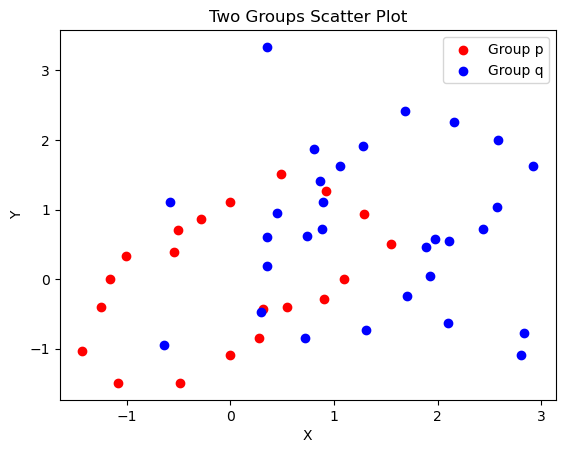

In [146]:
import matplotlib.pyplot as plt
def visualize_2d(p,q):
    x1,y1 = p[:,0].T,p[:,1].T
    x2,y2 = q[:,0].T,q[:,1].T
    plt.scatter(x1, y1, color='red', label='Group p')
    plt.scatter(x2, y2, color='blue', label='Group q')
    plt.legend()
    plt.title('Two Groups Scatter Plot')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()

visualize_2d(p,q)

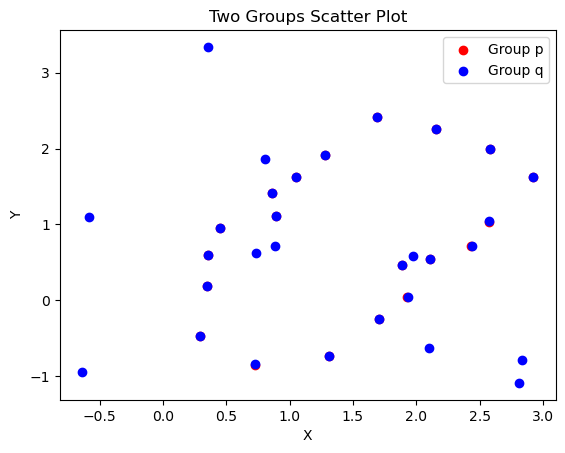

translation error of bound 1: 0.0009988127214888695


In [147]:
# for bounds 1
p_trans = (p+t1) @ r1.T
visualize_2d(p_trans,q)
translation_error1 = np.linalg.norm(t1 - np.squeeze(t_gt))
print("translation error of bound 1:",translation_error1)

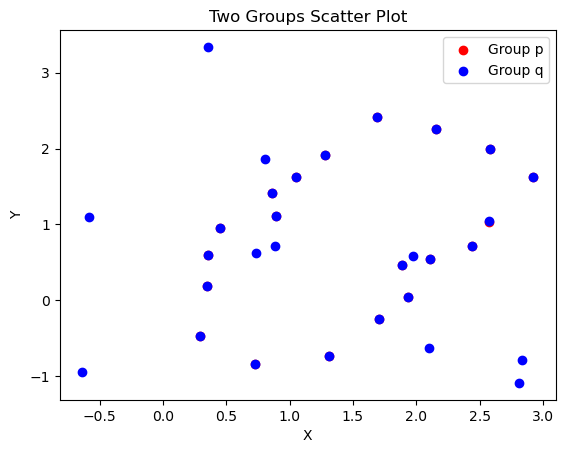

translation error of bound 2: 0.0003909203978461417


In [148]:
# for bounds 2
p_trans = (p+t2) @ r2.T
visualize_2d(p_trans,q)
translation_error2 = np.linalg.norm(t2 - np.squeeze(t_gt))
print("translation error of bound 2:",translation_error2)